<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20di%20Serie%20Temporali/04_Recurrent_Neural_Networks.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Neural Networks - Recurrent Neural Networks using SimpleRNN and GRU

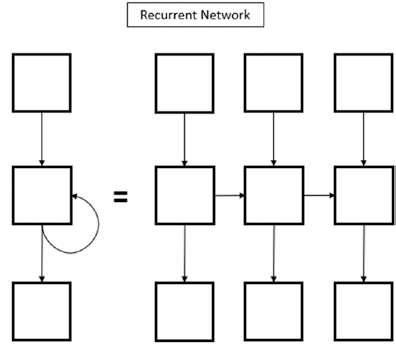

The difference in the RNN block is that there is a feedback loop. Where each input of a fully connected network is completely
independent, the inputs of an RNN have a feedback relation with each other. This makes the model good to fit data that has sequences, like Times series or written text.
Due to this architecture difference, there is not just one input in each unit, but there are two.

Also, the tanh activation layer is the most common for RNN instead of the ReLU. The reason for this is that for long sequences, the ReLU layer suffers from the exploding gradient problem: the repeated multiplication with weights is acting like an exponentiation that
makes it explode. The tanh activation layer does not have this problem, as the values are forced to stay between -1 and 1.

#### 1 - Importing Data

Data: Jena Climate dataset

Period of Record: From 2009 to 2016

Number of observations: 420551
Number of variables: 2
Variable name definitions:

1.   date - sample date in YYMMDD hh:mm:ss format
2.   co2 - CO2 Concentration in  ppmv


The data returned by load_pandas contains the dates as the index.

Source: https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip.

In [18]:
import keras
import pandas as pd
from zipfile import ZipFile
import os
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)
del zip_file
df = df.drop('Date Time', axis=1)
cols = ['p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 'sh',
'H2OC', 'rho', 'wv', 'mwv', 'wd']
df.columns = cols
df.head()


,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,mwv,wd
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


#### 2 - Data Preparation - Scaling and creation of the Sequence Data

In this example, we’ll do a forecast of the temperature 12 hours later.
Now what we did in the fully connected model was to create lagged variables. There was one y variable (which was not lagged), and the independent variables were lagged values of the y variable and a lot of other variables. The first lag was at 72 time steps, so that the model would use the data from 12 hours ago to predict the now.

In the RNN, this is not what we should do, as the RNN learns sequences. A big jump of 72 time steps is not really respecting the sequential variation. Yet we do not just want to predict one time step later, as that would mean that we predict the temperature in 10 minutes from now. What we will do is create a matrix of y variables, with lags as well. Before, we wanted to predict one value 72 time steps into the future, but let’s model to predict each of those 72. This approach is called multistep forecasting.

Other than that, for this model we will use only the temperature data and not the other variables (in order to simplify the sequences construction).

In [20]:
df = df[['T']] ## Keep only temperature data

Next, we proceed with data standardization using the MinMaxScaler

In [21]:
# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = ['T'])

Then, we prepare the sequence data

In [22]:
ylist = list(df['T'])
n_future = 72
n_past = 3*72
total_period = 4*72

idx_end = len(ylist)
idx_start = idx_end - total_period
X_new = []
y_new = []
while idx_start > 0:
  x_line = ylist[idx_start:idx_start+n_past]
  y_line = ylist[idx_start+n_past:idx_start+total_period]
  X_new.append(x_line)
  y_new.append(y_line)
  idx_start = idx_start - 1

# converting list of lists to numpy array
import numpy as np
X_new = np.array(X_new)
y_new = np.array(y_new)

#### 3 - Split into Train and Test sets and Data Reshape

Now that we have obtained an X and a Y matrix for the model training, as always we need to split it into a train and test set in order to be able to do a fair model evaluation.

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42)

A final step is necessary for fitting the SimpleRNN. The SimpleRNN layer needs
an input format that is 3D, and the shape has to correspond to (n_samples, n_timesteps, n_features). This can be obtained using reshape. This reshape is, unfortunately, necessary sometimes when using Keras, as it is very specific as to the exact shape of the input data.

In [27]:
batch_size = 32
n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1
X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features )
X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features )

#### 4 - Simple RNN Neural Network Construction

The SimpleRNN is a basic RNN cell that is represented by the following architecture:

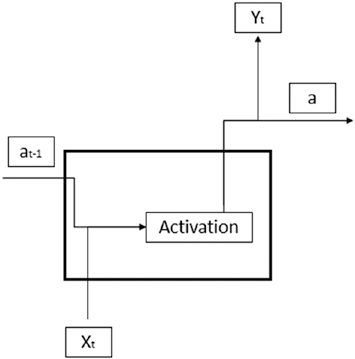

The overall architecture will look as follows:
*   Activation Function: tanh
*   Optimizer: Adam
*   Learning rate: 0.001
*   Batch size: 32 (reduce this if you don’t have enough RAM)
*   Epochs: 5


In [28]:
import random
random.seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
simple_model = Sequential([
SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features)),
Dense(y_train.shape[1]),
])
simple_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 72)                648       
                                                                 
Total params: 728 (2.84 KB)
Trainable params: 728 (2.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model

In [29]:
simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.001),
loss='mean_absolute_error',
metrics=['mean_absolute_error'],
)

Fit the model (this step can take long time to complete) and retrieve predictions. In this case, the result is not completeley reproducible due to the randomness

In [30]:
smod_history = simple_model.fit(X_train_rs, y_train,
validation_split=0.2,
epochs=5,
batch_size=batch_size,
shuffle = True
)
preds = simple_model.predict(X_test_rs)

Epoch 1/5
7040/7040 [==============================] - 246s 35ms/step - loss: 0.0505 - mean_absolute_error: 0.0505 - val_loss: 0.0461 - val_mean_absolute_error: 0.0461
Epoch 2/5
7040/7040 [==============================] - 245s 35ms/step - loss: 0.0456 - mean_absolute_error: 0.0456 - val_loss: 0.0452 - val_mean_absolute_error: 0.0452
Epoch 3/5
7040/7040 [==============================] - 260s 37ms/step - loss: 0.0443 - mean_absolute_error: 0.0443 - val_loss: 0.0432 - val_mean_absolute_error: 0.0432
Epoch 4/5
7040/7040 [==============================] - 240s 34ms/step - loss: 0.0430 - mean_absolute_error: 0.0430 - val_loss: 0.0428 - val_mean_absolute_error: 0.0428
Epoch 5/5
4334/4334 [==============================] - 44s 10ms/step


Plot the training history

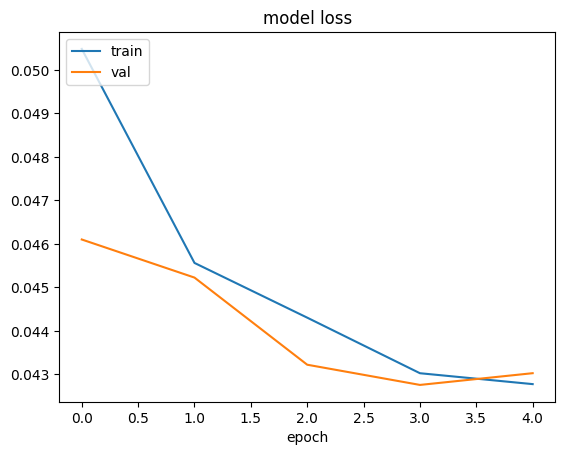

In [31]:
import matplotlib.pyplot as plt
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### 5 - Gated Recurrent Unit (GRU) Neural Network Construction


GRU is a more advanced layer, where we have an extra parameter inside the cell which has to be extimated:

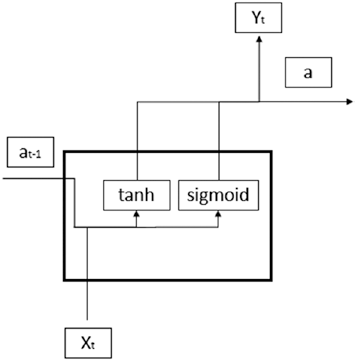

Due to this difference, GRU obtains better general performances than the
SimpleRNN, especially in the identification of long term trends.

In [32]:
random.seed(42)
from tensorflow.keras.layers import GRU
simple_model = Sequential([
GRU(8, activation='tanh',input_shape=(n_timesteps, n_features)),
Dense(y_train.shape[1]),
])
simple_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 72)                648       
                                                                 
Total params: 912 (3.56 KB)
Trainable params: 912 (3.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile and fit the model

In [34]:
simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.01),
loss='mean_absolute_error',
metrics=['mean_absolute_error'],
)
smod_history = simple_model.fit(X_train_rs, y_train,
validation_split=0.2,epochs=10,
batch_size=batch_size,
shuffle = True
)

Epoch 1/5
7040/7040 [==============================] - 488s 69ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 2/5
7040/7040 [==============================] - 450s 64ms/step - loss: 0.0282 - mean_absolute_error: 0.0282 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 3/5
7040/7040 [==============================] - 449s 64ms/step - loss: 0.0279 - mean_absolute_error: 0.0279 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 4/5
7040/7040 [==============================] - 473s 67ms/step - loss: 0.0276 - mean_absolute_error: 0.0276 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 5/5
7040/7040 [==============================] - 462s 66ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383


Plot the training history

4334/4334 [==============================] - 58s 13ms/step
0.8276155906918117


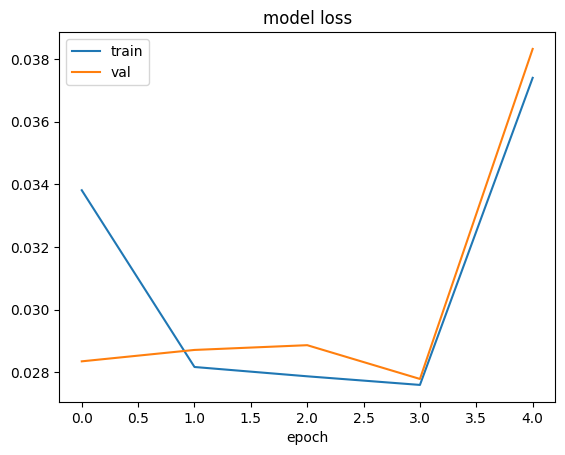

In [35]:
from sklearn.metrics import r2_score
preds = simple_model.predict(X_test_rs)
print(r2_score(preds, y_test))
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()